<a href="https://colab.research.google.com/github/nickash2/NeuralNets-Project/blob/main/Copy_of_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
df = pd.read_excel('M3C.xls', sheet_name='M3Month')
df.dropna(axis=1, inplace=True)
df.head()

,Series,N,NF,Category,Starting Year,Starting Month,1,2,3,4,...,57,58,59,60,61,62,63,64,65,66
0,N1402,68,18,MICRO,1990,1,2640.0,2640.0,2160.0,4200.0,...,1560.0,1440.0,240.0,1800.0,4680.0,1800.0,1680.0,3720.0,2160.0,480.0
1,N1403,68,18,MICRO,1990,1,1680.0,1920.0,120.0,1080.0,...,960.0,1320.0,1080.0,1680.0,1080.0,840.0,840.0,600.0,1320.0,1320.0
2,N1404,68,18,MICRO,1990,1,1140.0,720.0,4860.0,1200.0,...,4650.0,2550.0,8640.0,7680.0,6720.0,5190.0,5190.0,5910.0,4800.0,5640.0
3,N1405,68,18,MICRO,1990,1,180.0,940.0,2040.0,800.0,...,5760.0,2280.0,12300.0,8800.0,9660.0,5860.0,6600.0,8100.0,7760.0,6940.0
4,N1406,68,18,MICRO,1990,1,2000.0,1550.0,4450.0,3050.0,...,9550.0,6450.0,9800.0,12450.0,10050.0,8400.0,10000.0,10950.0,10700.0,8800.0


In [ ]:
# Assuming df is your DataFrame with wide-format data
df_long = pd.melt(df, id_vars=['Series', 'N', 'NF', 'Category', 'Starting Year', 'Starting Month'],
                  var_name='Month', value_name='Value')

df_long

,Series,N,NF,Category,Starting Year,Starting Month,Month,Value
0,N1402,68,18,MICRO,1990,1,1,2640.0
1,N1403,68,18,MICRO,1990,1,1,1680.0
2,N1404,68,18,MICRO,1990,1,1,1140.0
3,N1405,68,18,MICRO,1990,1,1,180.0
4,N1406,68,18,MICRO,1990,1,1,2000.0
...,...,...,...,...,...,...,...,...
94243,N2825,71,18,OTHER,0,0,66,2575.7
94244,N2826,71,18,OTHER,0,0,66,2147.4
94245,N2827,71,18,OTHER,0,0,66,2129.8
94246,N2828,71,18,OTHER,0,0,66,2768.9


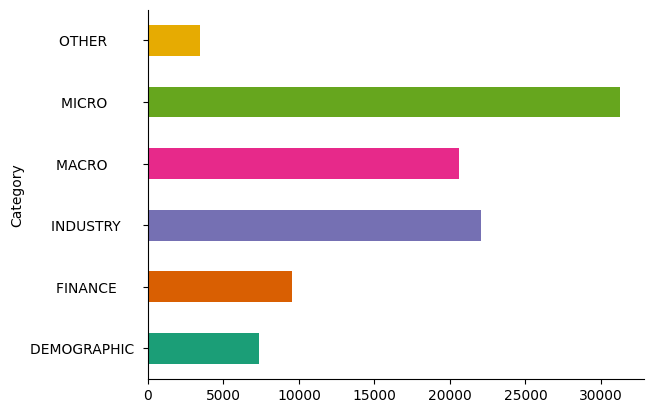

In [ ]:
# @title Category

from matplotlib import pyplot as plt
import seaborn as sns
df_long.groupby('Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
print(df_long['Category'].unique())


['MICRO       ' 'INDUSTRY    ' 'MACRO       ' 'FINANCE     '
 'DEMOGRAPHIC ' 'OTHER       ']


In [ ]:
df_monthly = df_long[df_long['Category'] == 'MICRO       ']
df_monthly.head()

,Series,N,NF,Category,Starting Year,Starting Month,Month,Value
0,N1402,68,18,MICRO,1990,1,1,2640.0
1,N1403,68,18,MICRO,1990,1,1,1680.0
2,N1404,68,18,MICRO,1990,1,1,1140.0
3,N1405,68,18,MICRO,1990,1,1,180.0
4,N1406,68,18,MICRO,1990,1,1,2000.0


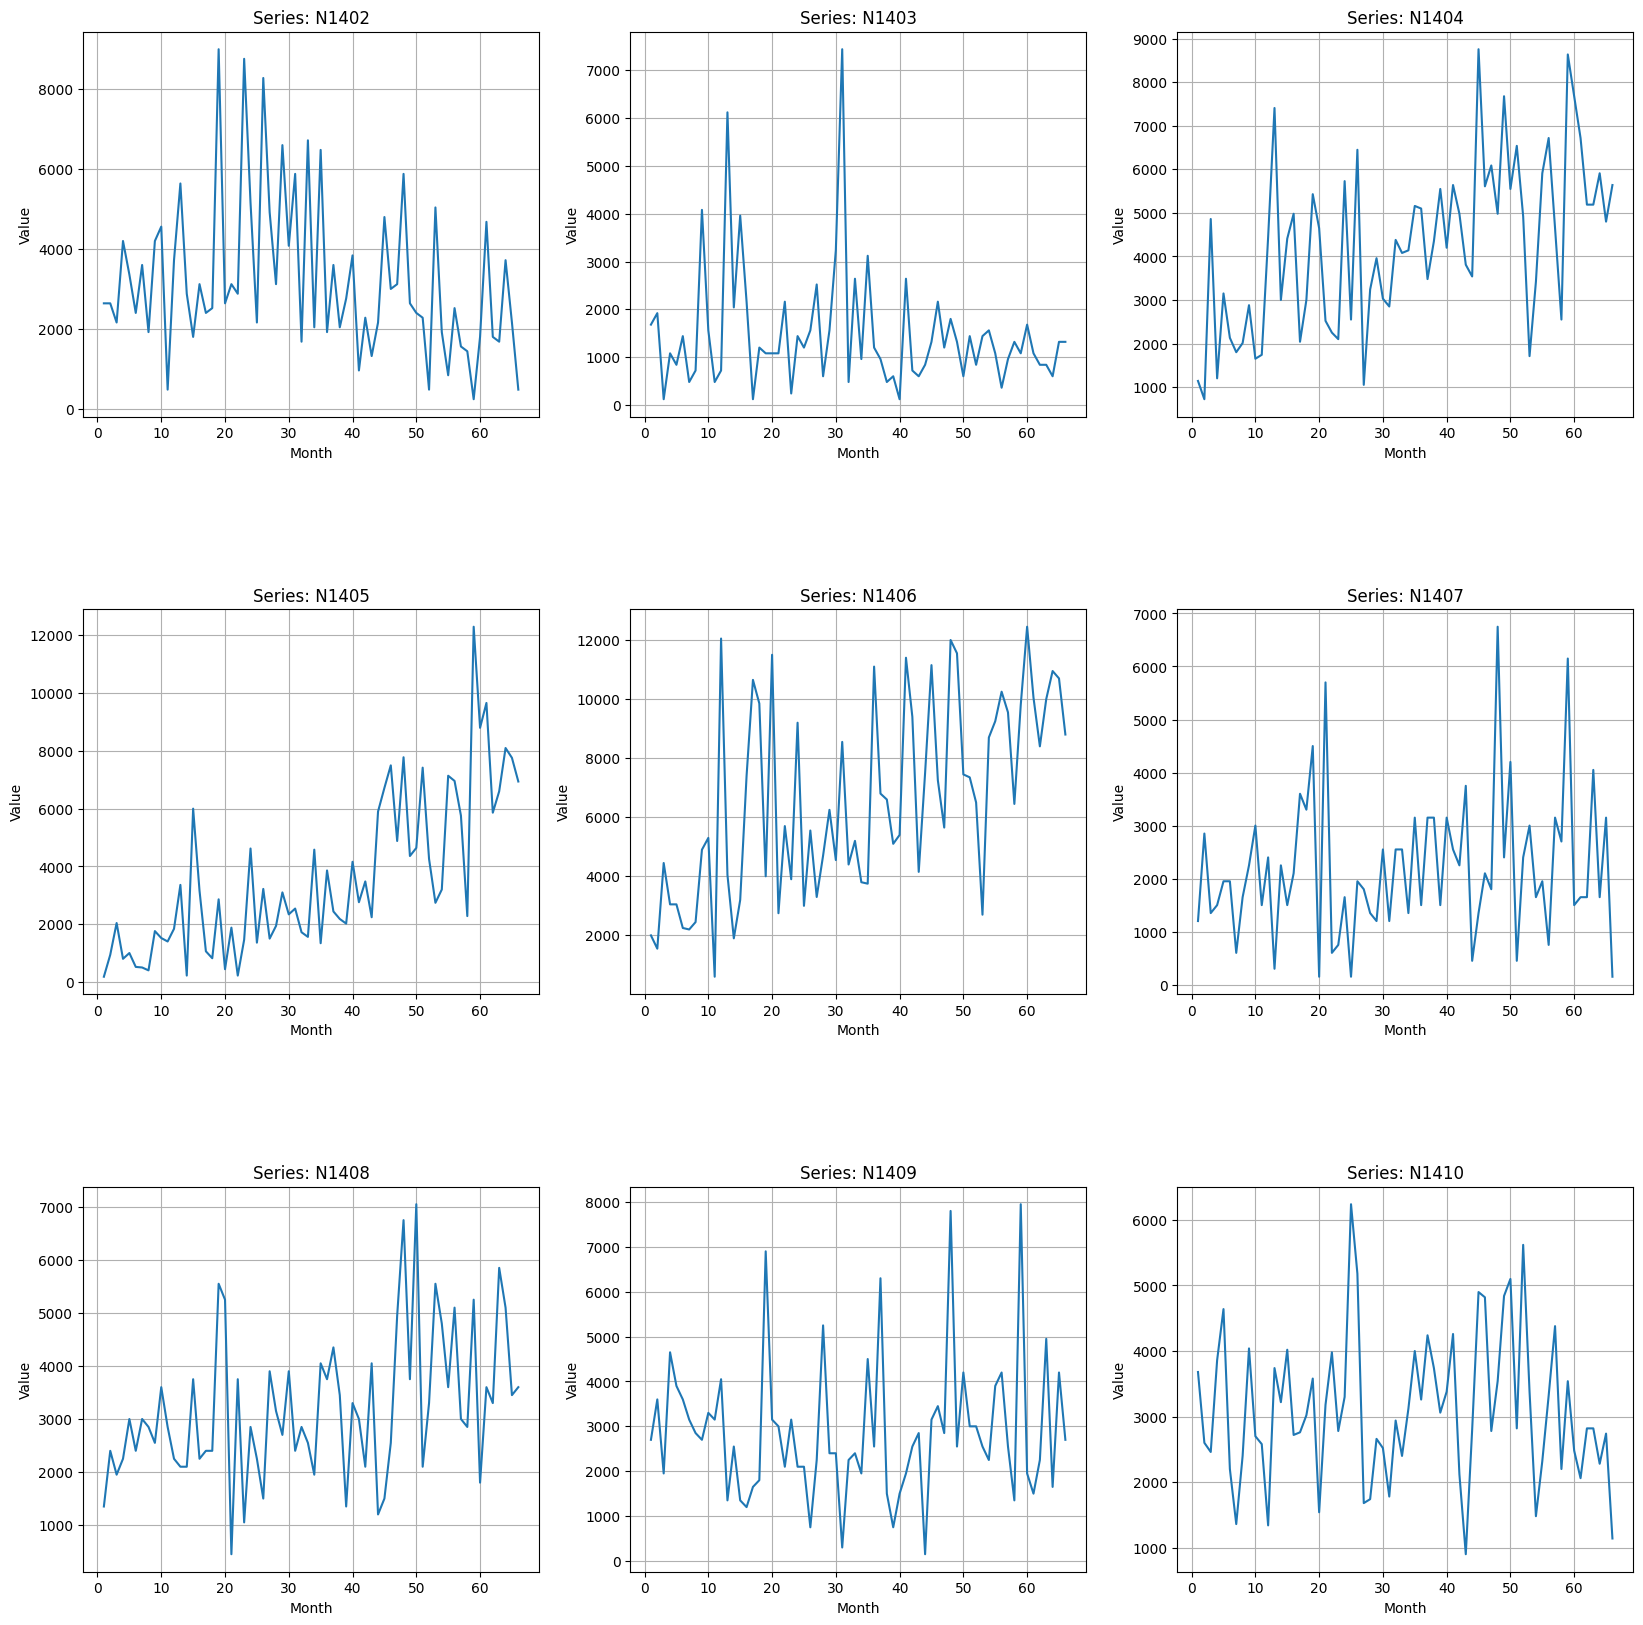

In [ ]:
series_to_plot = df_long['Series'].unique()

# Calculate the number of rows needed for subplots
n = 9
ncols = 3
nrows = n // ncols + n % ncols
pos = range(1, n + 1)

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=.5, wspace=.2)

for k, series in zip(pos, series_to_plot):

    # Filter df_monthly for the current series
    series_data = df_monthly[df_monthly['Series'] == series]

    # Create subplot
    ax = fig.add_subplot(nrows, ncols, k)

    # Plot the series
    ax.plot(series_data['Month'], series_data['Value'])
    ax.set_xlabel('Month')
    ax.set_ylabel('Value')
    ax.set_title(f'Series: {series}')
    ax.grid(True)

plt.show()


plt.show()

In [ ]:
import statsmodels.api as sm

series_to_plot = df_monthly['Series'].unique()

# Create an empty DataFrame to store the detrended and de-seasonalized data
df_detrended = pd.DataFrame()

for series in series_to_plot:
    # Filter the DataFrame for the current series
    df_filtered = df_monthly[df_monthly['Series'] == series]

    # Decompose the data
    decomposition = sm.tsa.seasonal_decompose(df_filtered['Value'], model='additive', period=12)

    # Get the detrended and de-seasonalized data
    detrended_deseasonalized = decomposition.resid

    # Create a DataFrame for the current series
    df_current = df_filtered.copy()
    df_current['Value'] = detrended_deseasonalized

    # Append the current DataFrame to the main DataFrame
    df_detrended = pd.concat([df_detrended, df_current])

# Now df_detrended contains the detrended and de-seasonalized data

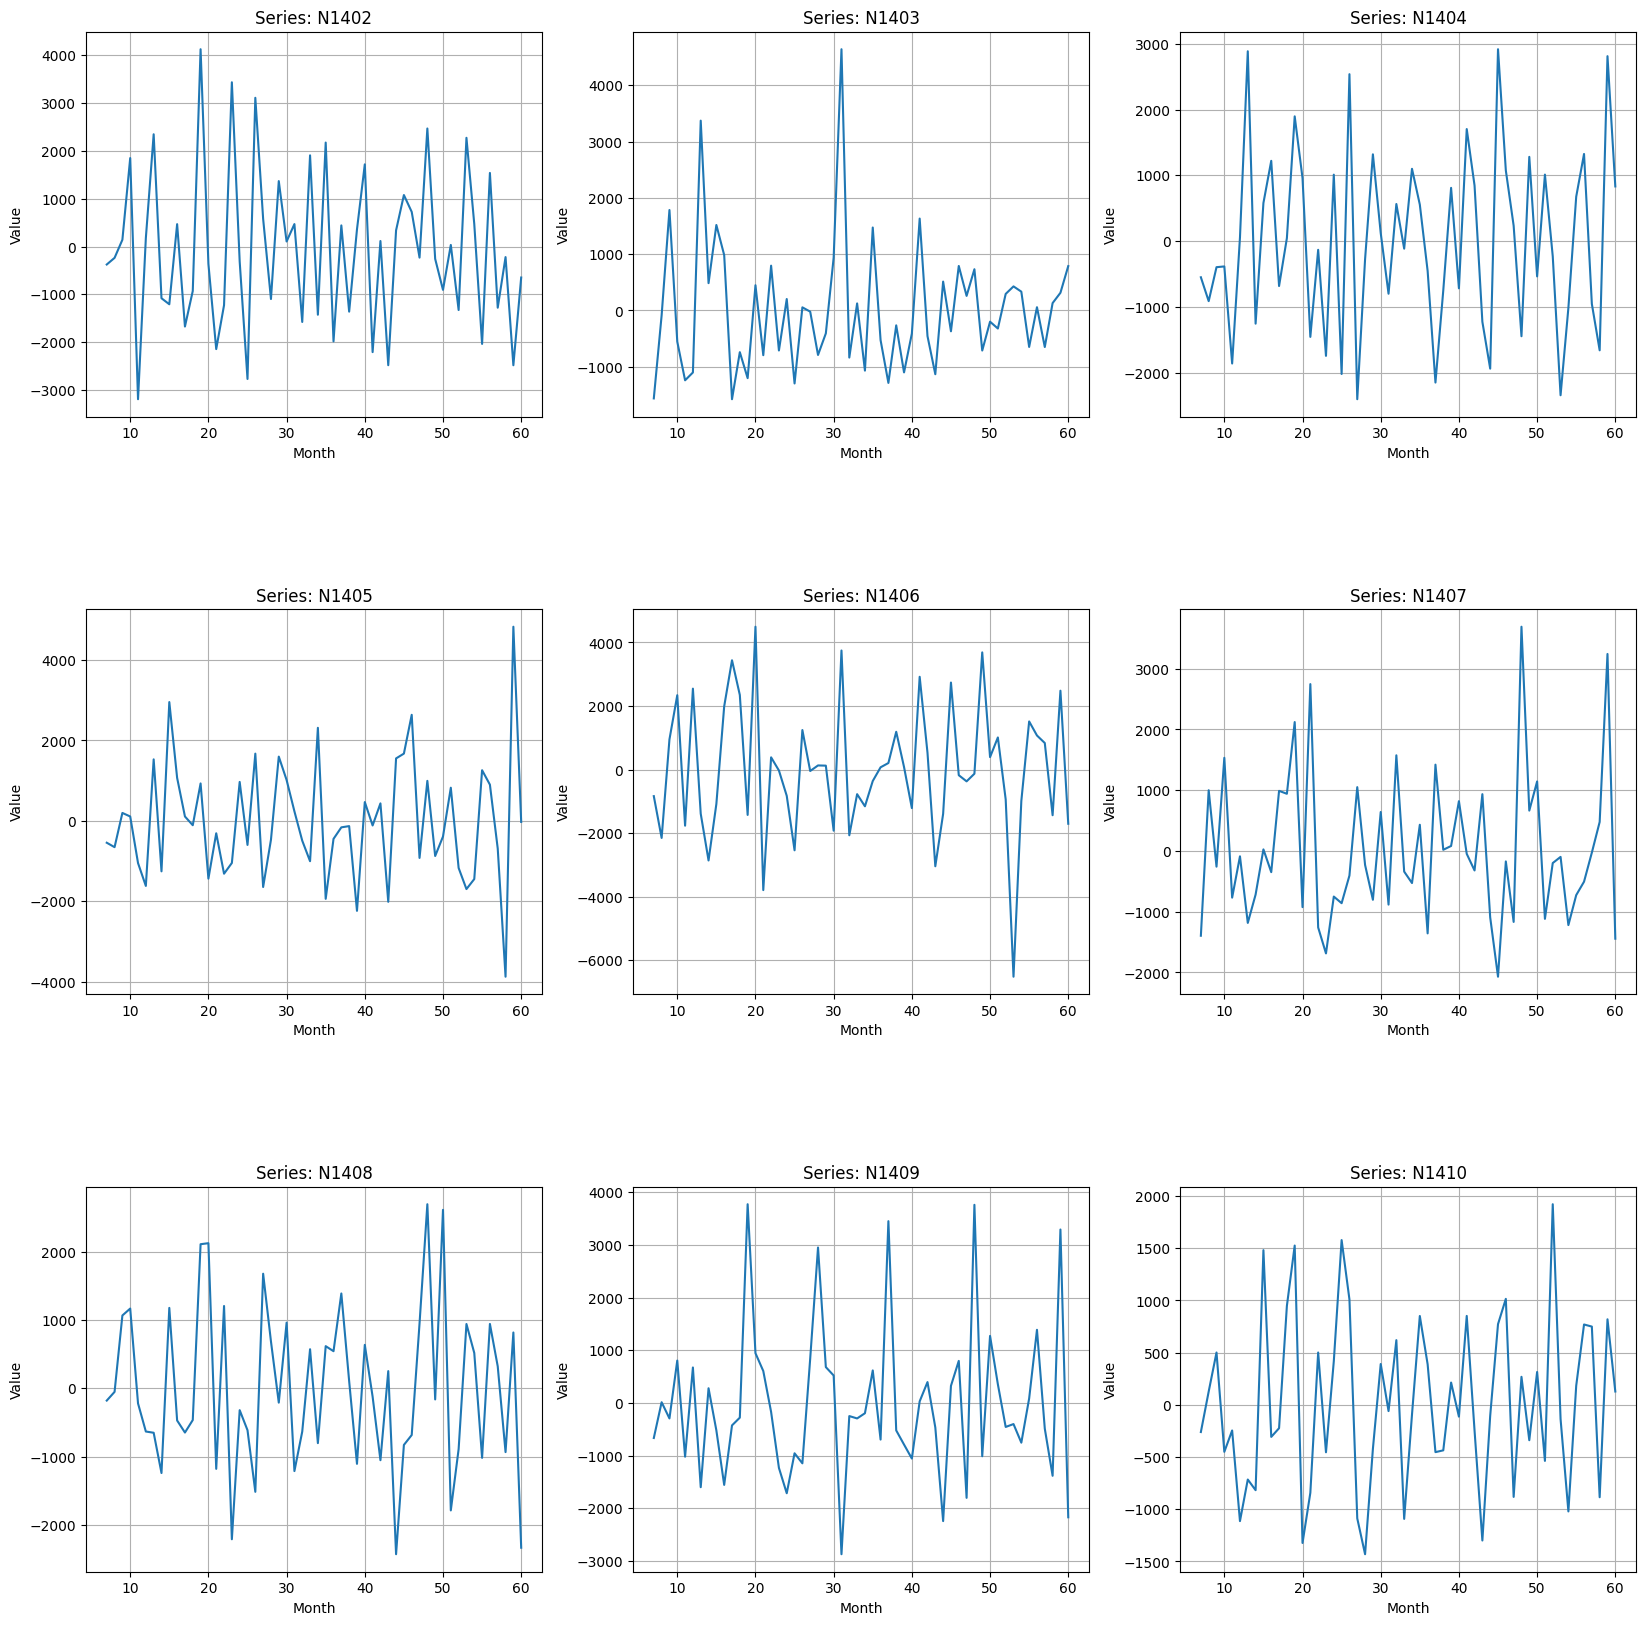

In [ ]:
series_to_plot = df_long['Series'].unique()

# Calculate the number of rows needed for subplots
n = 9
ncols = 3
nrows = n // ncols + n % ncols
pos = range(1, n + 1)

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=.5, wspace=.2)

for k, series in zip(pos, series_to_plot):

    # Filter df_monthly for the current series
    series_data = df_detrended[df_detrended['Series'] == series]

    # Create subplot
    ax = fig.add_subplot(nrows, ncols, k)

    # Plot the series
    ax.plot(series_data['Month'], series_data['Value'])
    ax.set_xlabel('Month')
    ax.set_ylabel('Value')
    ax.set_title(f'Series: {series}')
    ax.grid(True)

plt.show()


plt.show()

In [50]:
missing_values = df.isna().sum()
missing_values

Series           0
N                0
NF               0
Category         0
Starting Year    0
                ..
62               0
63               0
64               0
65               0
66               0
Length: 72, dtype: int64